# <span style="color:darkgreen">DATSCIW261 ASSIGNMENT 7</span>
#### MIDS UC Berkeley, Machine Learning at Scale

<b>AUTHORS</b> : 
    - Rich Johnson
    - Charles Maalouf
    - Rajesh Thallam
<b>EMAIL</b>  : richard.johnson@ischool.berkeley.edu, cmaalouf@berkeley.edu, rajesh.thallam@ischool.berkeley.edu <br>
<b>WEEK</b>   : 9 <br>
<b>DATE</b>   : 27-Oct-15

***

<h2><span style="color:dodgerblue;font:12px">HW7.0</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Shortest path graph distances (toy networks)</b></span>

<span style="color:CornflowerBlue "> Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target. Work locally for this part of the assignment, and use both of the undirected and directed toy networks. To proof you code's function, run the following jobs </span> <br><br>
<span style="color:CornflowerBlue "> - shortest path in the undirected network from node 1 to node 4</span><br>
<span style="color:CornflowerBlue "> - shortest path in the directed network from node 1 to node 5</span>

<span style="color:cornflowerblue; font-size: 120%;"><b>Single Source Shortest Path<b></span><br>

In [11]:
%%writefile dijkstra.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.emr import EMRJobRunner
from boto.s3.key import Key
import ast
import sys
import boto

class MRDijkstra(MRJob):    
    # set command line option to accept start and end node
    def configure_options(self):
        super(MRDijkstra, self).configure_options()

        self.add_passthrough_option('--startnode', default='1', type=str, help='starting node for single source shortest path')
        self.add_passthrough_option('--endnode', default=None, type=str, help='target node to be visited')
        self.add_passthrough_option('--bucket', default=None, type=str, help='bucket to write secondary output')
        self.add_passthrough_option('--runmode', default=None, type=str, help='local or emr')

    # initialize mapper with start node
    def mapper_init(self):
        self.startnode = self.options.startnode

    # for each node emit adjacency list with path and distance
    # (node, [edges, distance, path, state]))
    def mapper(self, _, line):
        # parse input
        line = line.strip()
        data = line.split('\t')
        values = data[1].strip('"').split("|")
        
        # init variables
        node = None
        edges = None
        path = list()
        dist = sys.maxint
        state = None
        
        # parse the input for first iteration
        if len(values) >= 1:
            node = data[0].strip('"')
            edges = ast.literal_eval(values[0])
        # parse the input for subsequent iterations 
        if len(values) == 4:
            dist = int(values[1])
            path = ast.literal_eval(values[2])
            state = values[3]
        
        # for first pass set start node to q status
        if state == None and self.startnode == node:
            state = 'q'
            dist = 0
        
        # for frontier nodes emit node with its neighbors
        if state == 'q':
            yield node, (edges, dist, path, 'v')
            path.append(node)

            for n in edges.iterkeys():
                yield n, (None, dist + 1, path, 'q')
        # else emit the current node
        else:
            yield node, (edges, dist, path, state)
          
    # initialize reducer
    def reducer_init(self):
        self.endnode = self.options.endnode     # read end node from command line
        self.target_reached = -1                # set if target node reached
        self.target_path = ""                   # set the path from source to target
        self.s3bucket = self.options.bucket     # intermediate s3 bucket to check for terminaton condition
        self.runmode = self.options.runmode     # read run mode - local or emr

    # reducers select the minimum of the distances for each destination node. 
    # each iteration of MapReduce job of the algorithm expands the "search 
    # frontier" by one hop.
    # if the node is set visited yield shortest distance and path
    def reducer(self, key, values):
        # initialize each node
        edges = {}
        dist = list()
        state = list()
        path = list()
        f_state = ''

        for v in values:
            v_edges = v[0]
            v_dist = v[1]
            v_path = v[2]
            v_state = v[3]

            if v_state == 'v':
                edges = v_edges
                dist.append(v_dist)
                path = v_path
                state.append(v_state)
                break
            
            # look for shortest distance
            dist.append(v_dist)
            state.append(v_state)

            # recover graph structure
            if v_edges != None:
                edges = v_edges
            if v_path != None and len(v_path) > 0:
                path = v_path
        
        # update shortest distance
        Dmin = min(dist)
        
        # keep track of pending and visited counters
        # set target reached when end node is reached
        if 'v' in state:
            f_state = 'v'
            if self.endnode != None and key.strip('"') == self.endnode:
                self.increment_counter('group', 'visited', 0)
                self.target_reached = 1
                self.target_path = str(key) + "\t" + str(edges) + '|' + str(Dmin) + '|' + str(path) + '|' + "F"
        elif 'q' in state:
            f_state = 'q'
            self.increment_counter('group', 'pending', 1)
        else:
            f_state = 'u'
            self.increment_counter('group', 'pending', 1)
            
        yield key, str(edges) + '|' + str(Dmin) + '|' + str(path) + '|' + f_state

    # if the target is reached, record the path and shortest 
    # distance on external S3 file if run on emr mode
    # if run in local, stream the output
    def reducer_final(self):
        if self.target_reached == 1:
            sys.stderr.write('Target reached')
            if self.runmode == 'emr':
                sys.stderr.write(self.target_path)
                s3_key = 'hw7/visited.txt'
                emr = EMRJobRunner()
                c = emr.fs.make_s3_conn()
                b = c.get_bucket(self.s3bucket)
                k = Key(b)
                k.key = s3_key
                k.set_contents_from_string(self.target_path)
                #self.write_to_s3(self.options.bucket, s3_key, self.target_path)
            else:
                yield self.target_path.split('\t')[0], self.target_path.split('\t')[1]
            
    # write to s3 bucket key with the string
    def write_to_s3(bucket, key, string):
        emr = EMRJobRunner()
        c = emr.fs.make_s3_conn()
        b = c.get_bucket(bucket)
        k = Key(b)
        k.key = key
        k.set_contents_from_string(string)
            
if __name__ == '__main__':
    MRDijkstra.run()

Overwriting dijkstra.py


<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on local<b></span><br>

In [16]:
%%writefile run_sssp.py
#!/usr/bin/python
from dijkstra import MRDijkstra
import time
import sys
import ast

# read source file, start and end nodes
SOURCE = sys.argv[1]
START_NODE = sys.argv[2]

if len(sys.argv) == 4:
    END_NODE = sys.argv[3]

start_time = time.time()
print "processing file {}".format(SOURCE)

# run on local
mr_job = MRDijkstra(args=[SOURCE, '--startnode', START_NODE, '--endnode', END_NODE, '-q', '-r', 'local', '--no-strict-protocol'])

counter = 0
prev_counters = [{}]

# run iterations until all nodes are visited or target is reached
while (1):
    with mr_job.make_runner() as runner: 
        counter += 1
        print "iteration #{}".format(counter)

        # run the mapreduce job 
        # each iteration of MapReduce job of the algorithm expands 
        # the "search frontier" by one hop
        runner.run()

        # stream the output of mapreduce to local
        f = open(SOURCE, 'w+')

        # read the output and write to local file
        for line in runner.stream_output():
            f.writelines(line)
            line = line.split('\t')

            node = line[0].strip('"')
            stripe = line[1].strip('"').split('|')
            edges = stripe[0]
            dist = stripe[1]
            path = stripe[2]
            state = stripe[3].replace('"', "")

            # if target node is reached expand the path
            if state[0] == 'F' :
                path = ast.literal_eval(path)
                shortest_path = '->'.join(path) + "->" + node
                min_distance = dist
            
        # termination condition
        # only for local mode
        # read the counters and find all nodes are visited or target reached
        # break the iterations
        curr_counters = runner.counters()
        visited = curr_counters[0]['group'].get('visited', -1)
        print curr_counters
        if curr_counters == [{}] or curr_counters == prev_counters or visited == 0:
            break
        prev_counters = runner.counters()

    f.close()

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the network from node {} to node {} is {} with distance of {}".format(START_NODE, END_NODE, shortest_path, min_distance)

Overwriting run_sssp.py


<span style="color:firebrick; font-size: 120%;"><b>Shortest path in the undirected network from node 1 to node 4</b></span><br>

In [17]:
!cp ./undirected_toy.txt ./undirected_toy.txt.out
!./run_sssp.py ./undirected_toy.txt.out 1 4

processing file ./undirected_toy.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 4}}]
iteration #2
[{'group': {'pending': 2}}]
iteration #3
[{'group': {'visited': 0}}]
Time taken to find shortest path = 7.21 seconds
shortest path in the network from node 1 to node 4 is 1->5->4 with distance of 2


<span style="color:firebrick; font-size: 120%;"><b>Shortest path in the directed network from node 1 to node 5</b></span><br>

In [6]:
!cp ./directed_toy.txt ./directed_toy.txt.out
!./run_sssp.py ./directed_toy.txt.out 1 5

processing file ./directed_toy.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 5}}]
iteration #2
[{'group': {'pending': 3}}]
iteration #3
[{'group': {'pending': 1}}]
iteration #4
[{'group': {'visited': 0}}]
Time taken to find shortest path = 9.64 seconds
shortest path in the network from node 1 to node 5 is 1->2->4->5 with distance of 3


<span style="color:firebrick; font-size: 120%;"><b>Explore network derived from the NLTK synonym database</b></span><br>

In [7]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_sssp.py ./synNet.txt.out 1 1462

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8270}}]
iteration #2
[{'group': {'pending': 8267}}]
iteration #3
[{'group': {'pending': 8265}}]
iteration #4
[{'group': {'pending': 8252}}]
iteration #5
[{'group': {'pending': 8158}}]
iteration #6
[{'group': {'pending': 7698}}]
iteration #7
[{'group': {'visited': 0, 'pending': 6097}}]
Time taken to find shortest path = 27.08 seconds
shortest path in the network from node 1 to node 1462 is 1->2->310->584->902->173->1462 with distance of 6


In [18]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_sssp.py ./synNet.txt.out 7827 536

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8270}}]
iteration #2
[{'group': {'pending': 8265}}]
iteration #3
[{'group': {'pending': 8158}}]
iteration #4
[{'group': {'visited': 0, 'pending': 7583}}]
Time taken to find shortest path = 14.58 seconds
shortest path in the network from node 7827 to node 536 is 7827->4655->631->536 with distance of 3


***

<h2><span style="color:dodgerblue;font:12px">HW7.1</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Exploratory data analysis (NLTK synonyms)</b></span>

<span style="color:CornflowerBlue "> Using MRJob, explore the synonyms network data. Consider plotting the degree distribution (does it follow a power law?), and determine some of the key features, like: number of nodes,  number links, or the average degree (i.e., the average number of links per node), etc...</span>

<span style="color:cornflowerblue; font-size: 120%;"><b>Exploratory Data Analysis<b></span><br>

In [19]:
%%writefile DegreeDistribution.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np

class MRDegreeDistribution(MRJob):

    def mapper(self, _, line):
        v, edges = line.strip().split('\t')
        edges = eval(edges)
        degree = len(edges.items())
        yield '%010d'%int(degree), 1
        
    def reducer(self, degree, count):
        yield int(degree), sum([i for i in count])

if __name__ == '__main__':
    MRDegreeDistribution.run()

Writing DegreeDistribution.py


In [28]:
%%writefile NodeEdgeCounts.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np

class MRNodeEdgeCounts(MRJob):

    def mapper(self, _, line):
        v, edges = line.strip().split('\t')
        edges = eval(edges)
        degree = len(edges.items())
        yield None, (1, degree)
        
    def reducer(self, _ ,count):
        data = list(count)
        nodes, edges = sum([i[0] for i in data]), sum([i[1] for i in data])
        yield nodes, edges

if __name__ == '__main__':
    MRNodeEdgeCounts.run()

Overwriting NodeEdgeCounts.py


<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on local<b></span><br>

In [91]:
%%writefile run_data_analysis.py
#!/usr/bin/env python

from NodeEdgeCounts import MRNodeEdgeCounts
from DegreeDistribution import MRDegreeDistribution
import time
import sys

SOURCE = sys.argv[1]
RUNMODE = sys.argv[2]

start_time = time.time()
print "processing file {}".format(SOURCE)

mr_job = MRNodeEdgeCounts(args=[SOURCE, '-r', RUNMODE, '--pool-emr-job-flows', '--max-hours-idle', '1'])
with mr_job.make_runner() as runner: 
    runner.run()
    nodes = []
    edges = []
    for line in runner.stream_output():
        nodes.append(int(line.split('\t')[0]))
        edges.append(int(line.split('\t')[1]))
        
    node_count = sum(nodes)
    edge_count = sum(edges)

mr_job = MRDegreeDistribution(args=[SOURCE, '-r', RUNMODE, '--pool-emr-job-flows', '--max-hours-idle', '1'])

f = open('./degree_distribution.txt', 'w+')
degree = {}

with mr_job.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        f.writelines(line)
        line = line.split('\t')
        degree[line[0]] = int(line[1])
        
f.close()
end_time = time.time()
print "Time taken to do analysis = {:.2f} seconds".format(end_time - start_time)

print "Number of nodes = {}".format(node_count)
print "Number of links = {}".format(edge_count)
print "Average Degree = {}".format(1.0 * sum(degree.values())/len(degree))

Overwriting run_data_analysis.py


<span style="color:cornflowerblue; font-size: 120%;">Running locally</span><br>

In [92]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_data_analysis.py ./synNet.txt.out local

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
No handlers could be found for logger "mrjob.runner"
Time taken to do analysis = 6.17 seconds
Number of nodes = 8271
Number of links = 61134
Average Degree = 99.6506024096


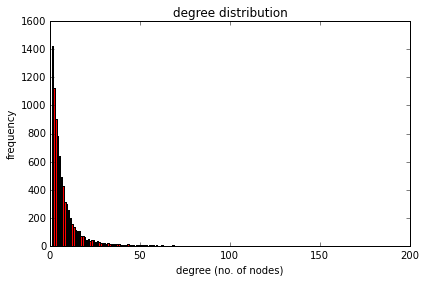

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

degree_d = {}
for line in open('./degree_distribution.txt').read().strip().split('\n'):
    degree, frequency = line.split('\t')
    degree = int(degree)
    frequency = int(frequency)
    degree_d[degree] = degree_d.get(degree, 0) + frequency

fig, ax = plt.subplots()
distribution = plt.bar(degree_d.keys(), degree_d.values(), color = "r")
plt.ylabel('frequency')
plt.xlabel('degree (no. of nodes)')
plt.title('degree distribution')

plt.tight_layout()
plt.show()

**The distribution of degree follows the power law as the degree increases frequency drops exponentially i.e. long tail distribution**

<span style="color:cornflowerblue; font-size: 120%;">Running on EMR</span><br>

In [66]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_data_analysis.py ./synNet.txt.out emr

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
No handlers could be found for logger "mrjob.runner"
Time taken to do analysis = 489.05 seconds
Number of nodes = 8271
Number of links = 61134

Average Degree = 99.6506024096


***

<h2><span style="color:dodgerblue;font:12px">HW7.2</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Shortest path graph distances (NLTK synonyms)</b></span>

<span style="color:CornflowerBlue "> Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, and apply it to the NLTK synonyms network dataset. Proof your code's function by running the job: <br>- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),<br>
and showing you code's output. Once again, your output should include the path and the distance. </span>

**We are using the same algorithm as in HW7.0 to find the shortest path. However, the driver script needs modification to read indices file and determine associated words**

<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on local<b></span><br>

In [68]:
%%writefile run_sssp_syn.py
#!/usr/bin/python
from dijkstra import MRDijkstra
import time
import sys
import ast

start_time = time.time()

# load indices file into memory
lookup = { k:v for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }

SOURCE = sys.argv[1]
START_WORD = sys.argv[2]
START_NODE = lookup[START_WORD]

if len(sys.argv) == 4:
    END_WORD = sys.argv[3]
    END_NODE = lookup[END_WORD]
    
# reverse lookup i.e. give word based on index
lookup = { v:k for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }
    
print "processing file {}".format(SOURCE)
print "start word {} ({})".format(START_WORD, START_NODE)
print "end word {} ({})".format(END_WORD, END_NODE)
    
# on local
mr_job = MRDijkstra(args=[SOURCE, '--startnode', START_NODE, '--endnode', END_NODE, '-q', '-r', 'local', '--no-strict-protocol'])

counter = 0
prev_counters = [{}]

while (1):
    with mr_job.make_runner() as runner: 
        counter += 1
        print "iteration #{}".format(counter)

        runner.run()

        f = open(SOURCE, 'w+')

        for line in runner.stream_output():
            f.writelines(line)
            line = line.split('\t')

            node = line[0].strip('"')
            stripe = line[1].strip('"').split('|')
            edges = stripe[0]
            dist = stripe[1]
            path = stripe[2]
            state = stripe[3].replace('"', "")

            if state[0] == 'F' :
                path = ast.literal_eval(path)
                words = [ lookup[w] for w in path ]
                end_word = lookup[node]
                shortest_path = ' -> '.join(words) + " -> " + end_word
                min_distance = dist
            
        curr_counters = runner.counters()
        visited = curr_counters[0]['group'].get('visited', -1)
        print curr_counters
        if curr_counters == [{}] or curr_counters == prev_counters or visited == 0:
            break
        
        prev_counters = runner.counters()

    f.close()

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the synonyms from word '{}' to word '{}' is [ {} ] with distance of {}".format(START_WORD, END_WORD, shortest_path, min_distance)

Writing run_sssp_syn.py


<span style="color:cornflowerblue; font-size: 120%;">Running locally</span><br>

In [69]:
print "downloading indices file"
!aws s3 cp s3://ucb-mids-mls-networks/synNet/indices.txt ./indices.txt
print "downloading source file"
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_sssp_syn.py ./synNet.txt.out walk Make

downloading indices file
download: s3://ucb-mids-mls-networks/synNet/indices.txt to ./indices.txt
downloading source file
download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
start word walk (7827)
end word Make (2246)
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8270}}]
iteration #2
[{'group': {'pending': 8265}}]
iteration #3
[{'group': {'pending': 8158}}]
iteration #4
[{'group': {'visited': 0, 'pending': 7583}}]
Time taken to find shortest path = 14.82 seconds
shortest path in the synonyms from word 'walk' to word 'Make' is [ walk -> passes -> draw -> Make ] with distance of 3


<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on EMR<b></span><br>

In [71]:
%%writefile run_sssp_syn_emr.py
#!/usr/bin/python
from dijkstra import MRDijkstra
from ReadShortestPath import MRReadShortestPath
from mrjob.emr import EMRJobRunner
from boto.s3.key import Key
import time
import sys
import ast
import boto

def check_sssp_completed():
    emr = EMRJobRunner()
    key = 'hw7/visited.txt'
    c = emr.fs.make_s3_conn()
    b = c.get_bucket('ucb-mids-mls-rajeshthallam') # substitute your bucket name here
    key_exists = b.get_key(key)
    
    if key_exists == None:
        return "-1"
    else:
        k = Key(b)
        k.key = key
        return k.get_contents_as_string()

def get_output(line):
    line = line.split('\t')

    node = line[0].strip('"')
    stripe = line[1].strip('"').split('|')
    edges = stripe[0]
    dist = stripe[1]
    path = stripe[2]
    state = stripe[3].replace('"', "")
        
    if state[0] == 'F':
        path = ast.literal_eval(path)
        words = [ lookup[w] for w in path ]
        end_word = lookup[node]
        shortest_path = ' -> '.join(words) + " -> " + end_word
        min_distance = str(dist)
            
        return [shortest_path, min_distance]
    
start_time = time.time()

# load indices file into memory
lookup = { k:v for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }

SOURCE = sys.argv[1] 
START_WORD = sys.argv[2]
START_NODE = lookup[START_WORD]

if len(sys.argv) == 4:
    END_WORD = sys.argv[3]
    END_NODE = lookup[END_WORD]
    
# reverse lookup i.e. give word based on index
lookup = { v:k for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }
    
print "processing file {}".format(SOURCE)
print "start word {} ({})".format(START_WORD, START_NODE)
print "end word {} ({})".format(END_WORD, END_NODE)

# iterate until shortest path from source to target is found
counter = 0
prev_counters = [{}]

while (1):
    counter += 1
    print "iteration #{}".format(counter)

    if counter == 1:
        s3_source = SOURCE
    else:
        s3_source = 's3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter-1) + "/"
    
    s3_target = 's3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter) + "/"
    
    print s3_source
    print s3_target
    
    mr_job = MRDijkstra(args=[s3_source, 
                          '--startnode', START_NODE, 
                          '--endnode', END_NODE, 
                          '--bucket', 'ucb-mids-mls-rajeshthallam',
                          '--runmode', 'emr',
                          '-r', 'emr',
                          '--pool-emr-job-flows',
                          '--max-hours-idle', '1',
                          '--output-dir', s3_target,
                          '--no-output',
                          '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()
    
    status = check_sssp_completed()
    if status != "-1":
        break
    else:
        print status
        
print get_output(status)
shortest_path, min_distance = get_output(status)

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the synonyms from word '{}' to word '{}' is [ {} ] with distance of {}".format(START_WORD, END_WORD, shortest_path, min_distance)

Overwriting run_sssp_syn_emr.py


<span style="color:cornflowerblue; font-size: 120%;">Running on EMR</span><br>

In [73]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/ssps --recursive
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/visited.txt

print "Downloading indices to local"
!aws s3 cp s3://ucb-mids-mls-networks/synNet/indices.txt ./indices.txt
    
# run job
!./run_sssp_syn_emr.py "s3://ucb-mids-mls-networks/synNet/synNet.txt" walk make

delete: s3://ucb-mids-mls-rajeshthallam/hw7/visited.txt
download: s3://ucb-mids-mls-networks/synNet/indices.txt to ./indices.txt
processing file s3://ucb-mids-mls-networks/synNet/synNet.txt
start word walk (7827)
end word make (536)
iteration #1
s3://ucb-mids-mls-networks/synNet/synNet.txt
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/
No handlers could be found for logger "mrjob.util"
-1
iteration #2
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/2/
-1
iteration #3
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/2/
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/3/
-1
iteration #4
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/3/
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/4/
['walk -> pass -> gives -> make', '3']
Time taken to find shortest path = 993.90 seconds
shortest path in the synonyms from word 'walk' to word 'make' is [ walk -> pass -> gives -> make ] with distance of 3


***

<h2><span style="color:dodgerblue;font:12px">HW7.3</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Exploratory data analysis (Wikipedia)</b></span>

<span style="color:CornflowerBlue "> Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? Be cautioned that Wikipedia is a directed network, where links are not symmetric. So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. </span>

<span style="color:cornflowerblue; font-size: 120%;">Running on EMR</span><br>

In [93]:
!./run_data_analysis.py "s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt" emr

processing file s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
No handlers could be found for logger "mrjob.runner"
Time taken to do analysis = 1079.69 seconds
Number of nodes = 5781290
Number of links = 142114057
Average Degree = 2803.72938894


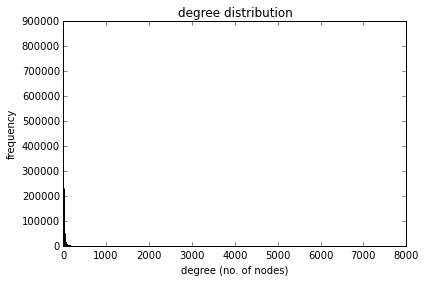

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

degree_d = {}
for line in open('./degree_distribution.txt').read().strip().split('\n'):
    degree, frequency = line.split('\t')
    degree = int(degree)
    frequency = int(frequency)
    degree_d[degree] = degree_d.get(degree, 0) + frequency

fig, ax = plt.subplots()
distribution = plt.bar(degree_d.keys(), degree_d.values(), color = "r")
plt.ylabel('frequency')
plt.xlabel('degree (no. of nodes)')
plt.xlim([0, 100])
plt.title('degree distribution')

plt.tight_layout()
plt.show()

***

<h2><span style="color:dodgerblue;font:12px">HW7.4</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Shortest path graph distances (Wikipedia)</b></span>

<span style="color:CornflowerBlue "> Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud. Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network. To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network. <br><br>When running your code on the Wikipedia network, proof its function by running the job: <br> - shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359), <br><br> and show your code's output. Once your code is running, find some other shortest paths and report your results.</span>

<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on EMR<b></span><br>

In [95]:
%%writefile run_sssp_syn_emr_hw7_4.py
#!/usr/bin/python
from dijkstra import MRDijkstra
from ReadShortestPath import MRReadShortestPath
from mrjob.emr import EMRJobRunner
from boto.s3.key import Key
import time
import sys
import ast
import boto

def check_sssp_completed():
    emr = EMRJobRunner()
    key = 'hw7/visited.txt'
    c = emr.fs.make_s3_conn()
    b = c.get_bucket('ucb-mids-mls-rajeshthallam') # substitute your bucket name here
    key_exists = b.get_key(key)
    
    if key_exists == None:
        return "-1"
    else:
        k = Key(b)
        k.key = key
        return k.get_contents_as_string()

def get_output(line):
    line = line.split('\t')

    node = line[0].strip('"')
    stripe = line[1].strip('"').split('|')
    edges = stripe[0]
    dist = stripe[1]
    path = stripe[2]
    state = stripe[3].replace('"', "")
        
    if state[0] == 'F':
        path = ast.literal_eval(path)
        words = [ lookup[w] for w in path ]
        end_word = lookup[node]
        shortest_path = ' -> '.join(words) + " -> " + end_word
        min_distance = str(dist)
            
        return [shortest_path, min_distance]
    
start_time = time.time()

# load indices file into memory
lookup = { k:v for k, v, v1, v2 in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }

SOURCE = sys.argv[1] 
START_WORD = sys.argv[2]
START_NODE = lookup[START_WORD]

if len(sys.argv) == 4:
    END_WORD = sys.argv[3]
    END_NODE = lookup[END_WORD]
    
# reverse lookup i.e. give word based on index
lookup = { v:k for k, v, v1, v2 in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }
    
print "processing file {}".format(SOURCE)
print "start word {} ({})".format(START_WORD, START_NODE)
print "end word {} ({})".format(END_WORD, END_NODE)

# iterate until shortest path from source to target is found
counter = 0
prev_counters = [{}]

while (1):
    counter += 1
    print "iteration #{}".format(counter)

    if counter == 1:
        s3_source = ['s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt']
    else:
        s3_source = ['s3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter-1) + "/"]
    
    s3_target = 's3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter) + "/"
    
    print s3_source
    print s3_target
    
    args = [
        '--startnode', START_NODE, 
        '--endnode', END_NODE, 
        '--bucket', 'ucb-mids-mls-rajeshthallam',
        '--runmode', 'emr',
        '-r', 'emr',
        '--pool-emr-job-flows',
        '--max-hours-idle', '1',
        '--output-dir', s3_target,
        '--no-output',
        '--no-strict-protocol'
    ] + s3_source
    
    mr_job = MRDijkstra(args)

    with mr_job.make_runner() as runner: 
        runner.run()
    
    status = check_sssp_completed()
    if status != "-1":
        break
    else:
        print status
        
print get_output(status)
shortest_path, min_distance = get_output(status)

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the synonyms from word '{}' to word '{}' is [ {} ] with distance of {}".format(START_WORD, END_WORD, shortest_path, min_distance)

Overwriting run_sssp_syn_emr_hw7_4.py


<span style="color:cornflowerblue; font-size: 120%;">Running on EMR</span><br>

In [96]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/ssps --recursive
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/visited.txt

# download indices to local
print "Downloading indices to local"
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt ./indices.txt
    
# run job
!./run_sssp_syn_emr_hw7_4.py "s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt" "Ireland" "University of California, Berkeley"

delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00000
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00011
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00003
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00002
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00006
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00004
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00008
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00007
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00001
A client error (404) occurred when calling the HeadObject operation: Key "hw7/visited.txt" does not exist
Completed 1 part(s) with ... file(s) remaining
download: s3://ucb-mids-mls-networks/wikipedia/indices.txt to ./indices.txt
processing file s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
start word

<span style="color:cornflowerblue; font-size: 120%;">Some other shortest paths</span><br>

In [ ]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/ssps --recursive
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/visited.txt

# download indices to local
print "Downloading indices to local"
#!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt ./indices.txt
    
# run job
!./run_sssp_syn_emr_hw7_4.py "s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt" "Barack Obama" "Britney Spears"

***

<h2><span style="color:dodgerblue;font:12px">HW7.5</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Conceptual exercise: Largest single-source network distances</b></span>

<span style="color:CornflowerBlue ">Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source. How would you implement this task?  How is this different from finding the shortest path graph distances? Is this task more difficult to implement than the shortest path distance? As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc.</span>

- We would implement this task by executing an exhaustive breadth-first search. 
- There is no point to switch to depth-first search as this implementation would have to be exhaustive either way. The stopping criteria would only be reached after a complete trace of the graph. This is unlike the shortest distance where the algorithm can be terminated upon discovery of the first path to the destination node. 
- This program would be more difficult to implement than the shortest path in some ways. In terms of runtime and iterations, both would be increased over the shortest path algorithm. 
- General system requirements should not change too greatly, there would be more potential paths to store, but in most cases that should not add too much to the memory footprint. 
- In terms of program structure, it would be simpler to implement the longest path algorithm, as it is the same as the shortest path, except that stopping criteria is removed, paths are stored, and finally the longest path is returned. All of the above holds for an unweighted graph. If a weighted graph is used, then an exhaustive search must be used and there are no real tradeoffs. 

<span style="color:firebrick">** -- END OF ASSIGNMENT 7 -- **</span>